# NDVI trend prediction
Earlier, we have extracted NDVI index by spatially aligning multiple satellite layers. The purpose of this notebook is to extract features to build AI models. NDVI index displays seasonal patterns and we need to capture the seasonality and predict the trend (over long term, whether the vegetation is increasing or decreasing). This notebook will extract trend as a feature and will then predict the value 2 weeks in advance based on 8 weeks of historical data.

## Spark settings and helper functions

In [1]:
spark.sparkContext._jsc.hadoopConfiguration().set('fs.cos.myCos.endpoint', 'xxx')
spark.sparkContext._jsc.hadoopConfiguration().set('fs.cos.myCos.iam.api.key', 'xxx')
spark.sparkContext._jsc.hadoopConfiguration().set('fs.cos.myCos.iam.service.id', 'xxx')

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20200811012712-0001
KERNEL_ID = 1de24559-c7ba-4714-8022-dd548731ab1d


In [2]:
#Helper functions

#plot timeseries
def plot_ts(timeseries):
    observations = timeseries.collect()
    import matplotlib.pyplot as plt
    x = [datetime.datetime(2010,4,23) + datetime.timedelta(days=14*o.time_tick) for o in observations]
    y = [o.value for o in observations]
    plt.xticks( rotation=25 )
    plt.plot(x, y)

#plot the seasonality and trend
def plot_decomposition(timeseries):
    observations = timeseries.collect()
    import matplotlib.pyplot as plt
    x = [datetime.datetime(2010,4,23) + datetime.timedelta(days=14*o.time_tick) for o in observations]
    trend = [o.value['trend'] for o in observations]
    seasonality = [o.value['seasonal'] for o in observations]
    plt.plot(x, trend)
    plt.plot(x, seasonality)
    plt.legend(['trend', 'seasonality'], loc='upper left')
    plt.xticks( rotation=25 )
    plt.show()

## Data selection
Read NDVI data for New Brunswick region for 5 years

In [3]:
df = spark.read.parquet('cos://xxx')
df.createOrReplaceTempView("raw_table")

In [4]:
averaged_values = spark.sql("""
        select date,
            avg(value) value
        from raw_table
        group by date
""")
averaged_values.createOrReplaceTempView("averaged_values_table")

#pick a location at random in sorted order
import pandas as pd
ndvi_values = spark.sql("""select to_timestamp(cast(date as string), "yyyyMMdd") as timestamp, value * 0.0001 as value from averaged_values_table where value > 5000.0""").toPandas()
ndvi_values[["value"]] = ndvi_values[["value"]].apply(pd.to_numeric)

In [5]:
ndvi_values['timestamp'].min()

Timestamp('2010-04-23 00:00:00')

## Timeseries feature extraction

In [6]:
# register timeseries functions
from sparktspy import SparkTSContext
tspy = SparkTSContext(spark, always_on_caching=False)

In [7]:
# create timeseries
import datetime
from tspy.builders.functions import *

granularity = datetime.timedelta(milliseconds=1)

ts = tspy.time_series.df(ndvi_values, "timestamp", "value", granularity)
ts = ts.with_trs(start_time=datetime.datetime(2010,4,23), granularity=datetime.timedelta(days=14))

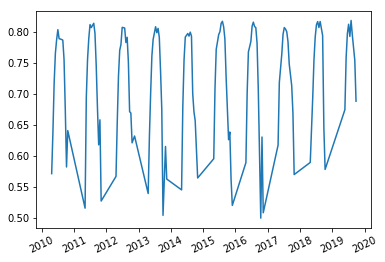

In [12]:
# Plot the timeseries
plot_ts(ts)

## Feature extraction

A simple function called `season_selector` allows for the discovery of seasonality on unknown timeseries data. Once discovered, we can use this to decompose the timeseries into trend, seasonal, and residual components. More info on this can be found [here](https://en.wikipedia.org/wiki/Decomposition_of_time_series).

In [9]:
# create a season selector
season_selector = tspy.forecasters.season_selector(max_season_length=52)

season_length = season_selector.get_season_length([o.value for o in ts.collect()])
ts_decomp = ts.transform(transformers.decompose(season_length, False))

print("Season length: ", season_length)

Season length:  13


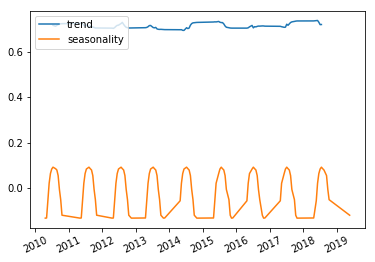

In [10]:
plot_decomposition(ts_decomp)

In [13]:
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(spark.sparkContext, 'xxx', 'xxx')
pc = project.project_context

## Extract feature vectors

In [14]:
import io

output = io.StringIO()
output.write('week_1,week_2,week_3,week_4,prediction\n')

csv_ts = ts_decomp.segment(5,1).map(lambda seg: ','.join(map(str, [o.value['trend'] for o in seg]))).filter(lambda s: 'nan' not in s)

for o in csv_ts.collect():
    output.write(o.value + "\n")

output.flush()
towrite = output.getvalue()

project.save_data('demo_predictions_new_brunswick.csv', towrite, overwrite=True)

{'file_name': 'demo_predictions_new_brunswick.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'satelliteimageryprocessing-donotdelete-pr-98kc2n8gkhwj3c',
 'asset_id': 'cb2c9f7c-989b-4d18-a7ce-ee72d1fd5fc7'}